# Load Olist Data into MySQL

This notebook loads the Olist E-commerce dataset CSV files into a MySQL database.

## Prerequisites
1.  Ensure you have a MySQL server running.
2.  Create a database (e.g., `olist_db`) in MySQL Workbench.
3.  Fill in your database credentials below.

In [3]:
# Install necessary libraries if not already installed
!pip install pandas sqlalchemy pymysql mysql-connector-python


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import os

# ==========================================
# CONFIGURATION - PLEASE UPDATE THESE VALUES
# ==========================================
DB_HOST = 'localhost'
DB_USER = 'root'        # Your MySQL username
DB_PASSWORD = 'your_password' # Your MySQL password
DB_NAME = 'my_company'    # Your Database name (Create this in Workbench first!)

# Create the database connection string
# We use mysql+pymysql, but you can also use mysql+mysqlconnector
connection_string = f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}"

try:
    engine = create_engine(connection_string)
    # Test connection
    with engine.connect() as conn:
        print("Successfully connected to the database!")
except Exception as e:
    print(f"Error connecting to database: {e}")
    print("Please check your credentials and make sure the database exists.")

Successfully connected to the database!


we have created the mini version of dataset and it only have 1500 or less rows in each table

In [5]:
# Define the path to your data directory
data_dir = os.path.join(os.getcwd(), 'small_data')

# List of files to ignore (if any)
ignore_files = []

def load_data_to_mysql(data_dir, engine):
    if not os.path.exists(data_dir):
        print(f"Data directory not found: {data_dir}")
        return

    files = [f for f in os.listdir(data_dir) if f.endswith('.csv') and f not in ignore_files]
    
    for filename in files:
        file_path = os.path.join(data_dir, filename)
        table_name = filename.replace('.csv', '').replace('olist_', '').replace('_dataset', '')
        
        print(f"Processing {filename} -> Table: {table_name}...")
        
        try:
            # Read CSV using chunks to avoid memory crashes with large files
            chunksize = 1000
            first_chunk = True
            
            for chunk in pd.read_csv(file_path, chunksize=chunksize):
                # Optional: specific column cleaning can go here
                
                # Write to SQL
                if_exists_action = 'replace' if first_chunk else 'append'
                chunk.to_sql(name=table_name, con=engine, if_exists=if_exists_action, index=False)
                first_chunk = False
                
            print(f"Successfully loaded {table_name}")
            
        except Exception as e:
            print(f"Failed to load {filename}: {e}")
            
load_data_to_mysql(data_dir, engine)

Processing category_translation.csv -> Table: category_translation...
Successfully loaded category_translation
Processing customers.csv -> Table: customers...
Successfully loaded customers
Processing geolocation.csv -> Table: geolocation...
Successfully loaded geolocation
Processing orders.csv -> Table: orders...
Successfully loaded orders
Processing order_items.csv -> Table: order_items...
Successfully loaded order_items
Processing order_payments.csv -> Table: order_payments...
Successfully loaded order_payments
Processing order_reviews.csv -> Table: order_reviews...
Successfully loaded order_reviews
Processing products.csv -> Table: products...
Successfully loaded products
Processing sellers.csv -> Table: sellers...
Successfully loaded sellers


In [6]:
# Verification: Check if tables exist
try:
    from sqlalchemy import inspect
    inspector = inspect(engine)
    tables = inspector.get_table_names()
    print("\nTables in database:")
    for table in tables:
        print(f"- {table}")
except Exception as e:
    print(f"Error verifying tables: {e}")


Tables in database:
- category_translation
- customers
- geolocation
- order_items
- order_payments
- order_reviews
- orders
- product_category_name_translation
- products
- sellers


# Category 1: Sales & Revenue Analysis

1. Total Revenue & Order Volume: What is the total revenue and the total number of orders placed on the platform?

In [10]:
query_revenue = """
SELECT 
    ROUND(SUM(price), 2) AS total_revenue, 
    COUNT(DISTINCT order_id) AS total_orders 
FROM order_items;
"""

df_revenue = pd.read_sql(query_revenue, con=engine)
print("Total Revenue and Total Orders:")
print(df_revenue)

Total Revenue and Total Orders:
   total_revenue  total_orders
0      169422.29          1324


2. Revenue Growth: What is the Month-over-Month (MoM) growth rate of total revenue?


In [ ]:
q2_sql = """
SELECT 
    month,
    revenue,
    @prev AS previous_revenue,
    ROUND(((revenue - @prev) / @prev) * 100, 2) AS growth_percentage,
    @prev := revenue
FROM (
    SELECT 
        DATE_FORMAT(o.order_purchase_timestamp, '%Y-%m') AS month,
        SUM(oi.price) AS revenue
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY month
    ORDER BY month
) AS MonthlyData, (SELECT @prev := NULL) AS vars;
"""
df2 = pd.read_sql(q2_sql, con=engine)
print("\n--- Q2: MoM Revenue Growth ---")
print(df2)

3. Top Revenue Categories: Which are the top 10 product categories (in English) that generate the highest revenue?

In [13]:
sql_q3 = """
SELECT 
    t.product_category_name_english,
    ROUND(SUM(oi.price), 2) AS total_revenue
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
JOIN product_category_name_translation t ON p.product_category_name = t.product_category_name
GROUP BY t.product_category_name_english
ORDER BY total_revenue DESC
LIMIT 10;
"""

df_3 = pd.read_sql(sql_q3, con=engine)
print("Total Revenue by categories:")
print(df_3)

Total Revenue by categories:
  product_category_name_english  total_revenue
0                    cool_stuff         659.90
1                 health_beauty         620.79
2                          toys         602.69
3                    housewares         560.29
4                consoles_games         543.99
5                 watches_gifts         534.80
6                sports_leisure         528.30
7                   electronics         526.44
8         computers_accessories         524.10
9         furniture_living_room         469.80


4. Average Order Value (AOV): What is the average value of an order, and how does it vary by state?

In [14]:
q4_sql = """
SELECT 
    c.customer_state,
    ROUND(SUM(oi.price) / COUNT(DISTINCT o.order_id), 2) AS avg_order_value
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_state
ORDER BY avg_order_value DESC;
"""
df4 = pd.read_sql(q4_sql, con=engine)
print("\n--- Q4: AOV by State ---")
print(df4)


--- Q4: AOV by State ---
Empty DataFrame
Columns: [customer_state, avg_order_value]
Index: []


5. Payment Preferences: What is the distribution of payment types (Credit Card, Boleto, etc.), and which one contributes the most to revenue?

In [15]:
q5_sql = """
SELECT 
    payment_type,
    COUNT(order_id) AS total_transactions,
    ROUND(SUM(payment_value), 2) AS total_value
FROM order_payments
GROUP BY payment_type
ORDER BY total_value DESC;
"""
df5 = pd.read_sql(q5_sql, con=engine)
print("\n--- Q5: Payment Preferences ---")
print(df5)


--- Q5: Payment Preferences ---
  payment_type  total_transactions  total_value
0  credit_card                1112    179172.21
1       boleto                 267     36526.11
2      voucher                  89      6580.55
3   debit_card                  32      3682.80


6. Installment Impact: Does a higher number of payment installments lead to a higher average order value?

In [16]:
q6_sql = """
SELECT 
    payment_installments,
    ROUND(AVG(payment_value), 2) AS avg_value
FROM order_payments
WHERE payment_type = 'credit_card'
GROUP BY payment_installments
ORDER BY payment_installments;
"""
df6 = pd.read_sql(q6_sql, con=engine)
print("\n--- Q6: Installment Impact ---")
print(df6)


--- Q6: Installment Impact ---
    payment_installments  avg_value
0                      1      99.30
1                      2     135.07
2                      3     144.36
3                      4     150.62
4                      5     164.71
5                      6     165.59
6                      7     166.56
7                      8     258.80
8                      9     128.82
9                     10     447.46
10                    12     185.78
11                    13     197.23


# Category 2: Logistics & Operations

7.Delivery Time: What is the average actual delivery time (in days) compared to the estimated delivery time?

In [17]:
q7_sql = """
SELECT 
    ROUND(AVG(DATEDIFF(order_delivered_customer_date, order_purchase_timestamp)), 2) AS avg_actual_delivery_days,
    ROUND(AVG(DATEDIFF(order_estimated_delivery_date, order_purchase_timestamp)), 2) AS avg_estimated_delivery_days
FROM orders
WHERE order_status = 'delivered';
"""
df7 = pd.read_sql(q7_sql, con=engine)
print("\n--- Q7: Delivery Time Performance ---")
print(df7)


--- Q7: Delivery Time Performance ---
   avg_actual_delivery_days  avg_estimated_delivery_days
0                      12.2                        24.29


8. Late Deliveries: What percentage of orders are delivered after the estimated delivery date?

In [18]:
q8_sql = """
SELECT 
    ROUND((COUNT(CASE WHEN order_delivered_customer_date > order_estimated_delivery_date THEN 1 END) * 100.0 / COUNT(*)), 2) AS late_delivery_percentage
FROM orders
WHERE order_status = 'delivered';
"""
df8 = pd.read_sql(q8_sql, con=engine)
print("\n--- Q8: Late Delivery Rate (%) ---")
print(df8)


--- Q8: Late Delivery Rate (%) ---
   late_delivery_percentage
0                      7.79


9. Freight Costs: Which states have the highest and lowest average freight values?

In [19]:
q9_sql = """
SELECT 
    c.customer_state,
    ROUND(AVG(oi.freight_value), 2) AS avg_freight_value
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_state
ORDER BY avg_freight_value DESC;
"""
df9 = pd.read_sql(q9_sql, con=engine)
print("\n--- Q9: Freight Costs by State ---")
print(df9.head(10))


--- Q9: Freight Costs by State ---
Empty DataFrame
Columns: [customer_state, avg_freight_value]
Index: []


10. Shipping Efficiency: What is the average time it takes for a seller to hand over an order to the carrier (order_delivered_carrier_date - order_purchase_timestamp)?

In [20]:
q10_sql = """
SELECT 
    ROUND(AVG(DATEDIFF(order_delivered_carrier_date, order_purchase_timestamp)), 2) AS avg_time_to_carrier_days
FROM orders
WHERE order_status = 'delivered' 
AND order_delivered_carrier_date IS NOT NULL;
"""
df10 = pd.read_sql(q10_sql, con=engine)
print("\n--- Q10: Seller Shipping Efficiency ---")
print(df10)


--- Q10: Seller Shipping Efficiency ---
   avg_time_to_carrier_days
0                      3.19


11. Order Status Distribution: What is the percentage of "Canceled" vs. "Delivered" orders?

In [21]:
q11_sql = """
SELECT 
    order_status,
    COUNT(*) AS total_count,
    ROUND((COUNT(*) * 100.0 / (SELECT COUNT(*) FROM orders)), 2) AS percentage
FROM orders
GROUP BY order_status
ORDER BY percentage DESC;
"""
df11 = pd.read_sql(q11_sql, con=engine)
print("\n--- Q11: Order Status Distribution ---")
print(df11)


--- Q11: Order Status Distribution ---
  order_status  total_count  percentage
0    delivered         1464       97.60
1      shipped           20        1.33
2  unavailable            5        0.33
3   processing            4        0.27
4     canceled            4        0.27
5     invoiced            3        0.20


# Category 3: Customer Insights

12. Customer Concentration: Which are the top 5 cities with the highest number of unique customers?

In [22]:
q12_sql = """
SELECT 
    customer_city, 
    COUNT(DISTINCT customer_unique_id) AS unique_customers
FROM customers
GROUP BY customer_city
ORDER BY unique_customers DESC
LIMIT 5;
"""
df12 = pd.read_sql(q12_sql, con=engine)
print("\n--- Q12: Top 5 Customer Cities ---")
print(df12)


--- Q12: Top 5 Customer Cities ---
    customer_city  unique_customers
0       sao paulo               242
1  rio de janeiro                97
2  belo horizonte                46
3        brasilia                35
4    porto alegre                24


13. Customer Retention (Loyalty): How many customers have placed more than one order (Repeat Buyers)?

In [23]:
q13_sql = """
SELECT 
    COUNT(*) AS repeat_customers_count
FROM (
    SELECT customer_unique_id
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    GROUP BY customer_unique_id
    HAVING COUNT(o.order_id) > 1
) AS repeat_buyers;
"""
df13 = pd.read_sql(q13_sql, con=engine)
print("\n--- Q13: Number of Repeat Buyers ---")
print(df13)


--- Q13: Number of Repeat Buyers ---
   repeat_customers_count
0                       0


14. Purchase Timing: On which day of the week and at what time of day do customers most frequently place orders?

In [24]:
q14_sql = """
SELECT 
    DAYNAME(order_purchase_timestamp) AS day_of_week,
    HOUR(order_purchase_timestamp) AS hour_of_day,
    COUNT(*) AS order_count
FROM orders
GROUP BY day_of_week, hour_of_day
ORDER BY order_count DESC
LIMIT 10;
"""
df14 = pd.read_sql(q14_sql, con=engine)
print("\n--- Q14: Peak Purchase Times (Top 10 Slots) ---")
print(df14)


--- Q14: Peak Purchase Times (Top 10 Slots) ---
  day_of_week  hour_of_day  order_count
0   Wednesday           13           27
1   Wednesday           16           27
2      Friday           13           21
3     Tuesday           21           20
4      Friday           11           20
5    Thursday           16           20
6   Wednesday           17           19
7    Thursday           22           19
8    Thursday           20           19
9    Thursday           14           19


15. Customer Lifetime Value (CLV): What is the total revenue generated by the top 1% of customers?

In [25]:
q15_sql = """
SELECT 
    SUM(total_spend) AS top_1_percent_revenue
FROM (
    SELECT 
        c.customer_unique_id, 
        SUM(oi.price) AS total_spend
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY c.customer_unique_id
    ORDER BY total_spend DESC
    LIMIT 15 
) AS top_customers;
"""
df15 = pd.read_sql(q15_sql, con=engine)
print("\n--- Q15: Revenue from Top 1% of Customers ---")
print(df15)


--- Q15: Revenue from Top 1% of Customers ---
  top_1_percent_revenue
0                  None


# Category 4: Seller & Product Performance

16. Top Performing Sellers: Who are the top 10 sellers based on revenue and their average review score?

In [26]:
q16_sql = """
SELECT 
    oi.seller_id, 
    ROUND(SUM(oi.price), 2) AS total_revenue,
    ROUND(AVG(orv.review_score), 2) AS avg_review_score
FROM order_items oi
JOIN order_reviews orv ON oi.order_id = orv.order_id
GROUP BY oi.seller_id
ORDER BY total_revenue DESC
LIMIT 10;
"""
df16 = pd.read_sql(q16_sql, con=engine)
print("\n--- Q16: Top Sellers (Revenue + Rating) ---")
print(df16)


--- Q16: Top Sellers (Revenue + Rating) ---
                          seller_id  total_revenue  avg_review_score
0  2528513dd95219a6013d4d05176e391a         499.00               4.0
1  527801b552d0077ffd170872eb49683b         154.90               5.0
2  4a3ca9315b744ce9f8e9374361493884         147.80               4.0
3  2d50d6282f8aa2257819a77bfaa0efe0         129.00               3.0
4  4a3ccda38b2129705f3fb522db62ca31         128.25               2.0
5  1025f0e2d44d7041d6cf58b6550e0bfa         105.00               5.0
6  3d871de0142ce09b7081e2b9d1733cb1          99.00               5.0
7  6560211a19b47992c3666cc44a7e94c0          69.00               5.0
8  620c87c171fb2a6dd6e8bb4dec959fc6          59.90               5.0
9  4c8b8048e33af2bf94f2eb547746a916          59.90               3.0


17. Product Rating by Category: Which product categories have the highest and lowest average review scores?

In [27]:
q17_sql = """
SELECT 
    t.product_category_name_english AS category,
    ROUND(AVG(orv.review_score), 2) AS avg_review_score,
    COUNT(*) AS total_reviews
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
JOIN product_category_name_translation t ON p.product_category_name = t.product_category_name
JOIN order_reviews orv ON oi.order_id = orv.order_id
GROUP BY category
ORDER BY avg_review_score DESC;
"""
df17 = pd.read_sql(q17_sql, con=engine)
print("\n--- Q17: Category Ratings (Top 5 and Bottom 5) ---")
print("Top 5:\n", df17.head(5))
print("\nBottom 5:\n", df17.tail(5))


--- Q17: Category Ratings (Top 5 and Bottom 5) ---
Top 5:
 Empty DataFrame
Columns: [category, avg_review_score, total_reviews]
Index: []

Bottom 5:
 Empty DataFrame
Columns: [category, avg_review_score, total_reviews]
Index: []


18. Review vs. Delivery: Is there a direct correlation between delivery delay (actual vs. estimated) and the review score given by the customer?

In [28]:
q18_sql = """
SELECT 
    CASE 
        WHEN o.order_delivered_customer_date <= o.order_estimated_delivery_date THEN 'On Time'
        ELSE 'Late'
    END AS delivery_status,
    ROUND(AVG(orv.review_score), 2) AS avg_review_score,
    COUNT(*) AS total_orders
FROM orders o
JOIN order_reviews orv ON o.order_id = orv.order_id
WHERE o.order_status = 'delivered'
GROUP BY delivery_status;
"""
df18 = pd.read_sql(q18_sql, con=engine)
print("\n--- Q18: Impact of Delay on Review Scores ---")
print(df18)


--- Q18: Impact of Delay on Review Scores ---
  delivery_status  avg_review_score  total_orders
0         On Time              4.44            27
1            Late              5.00             1


19. Low-Rated Products: Which products have more than 50 sales but an average review score of less than 3 (Potential quality issues)?

In [30]:
q19_sql = """
SELECT 
    product_id,
    COUNT(order_id) AS total_sold,
    ROUND(AVG(review_score), 2) AS avg_score
FROM (
    SELECT oi.product_id, oi.order_id, orv.review_score
    FROM order_items oi
    JOIN order_reviews orv ON oi.order_id = orv.order_id
) AS product_ratings
GROUP BY product_id
HAVING total_sold > 5 AND avg_score < 3
ORDER BY avg_score ASC;
"""
df19 = pd.read_sql(q19_sql, con=engine)
print("\n--- Q19: Low-Rated Products with Volume ---")
print(df19) # Note: With the 1500-row sample, this might be empty


--- Q19: Low-Rated Products with Volume ---
Empty DataFrame
Columns: [product_id, total_sold, avg_score]
Index: []


20. Underperforming Categories: Which product categories have a high number of photos but low sales conversion?

In [31]:
q20_sql = """
SELECT 
    t.product_category_name_english AS category,
    ROUND(AVG(p.product_photos_qty), 1) AS avg_photos,
    ROUND(SUM(oi.price), 2) AS total_revenue
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
JOIN product_category_name_translation t ON p.product_category_name = t.product_category_name
GROUP BY category
ORDER BY avg_photos DESC;
"""
df20 = pd.read_sql(q20_sql, con=engine)
print("\n--- Q20: Avg Photos vs. Category Revenue ---")
print(df20.head(10))


--- Q20: Avg Photos vs. Category Revenue ---
              category  avg_photos  total_revenue
0         garden_tools         6.0         179.99
1            telephony         5.0          34.99
2  luggage_accessories         4.0          89.99
3       consoles_games         3.5         543.99
4        watches_gifts         3.4         534.80
5                 toys         3.0         602.69
6      furniture_decor         3.0         160.79
7        health_beauty         2.7         620.79
8           cool_stuff         2.5         659.90
9          electronics         2.0         526.44


# Analysis & Visualization phase

In [36]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

1. Revenue Trends (Line Chart)
Question: How has the total monthly revenue evolved over the history of the dataset?

In [37]:
query21 = """
SELECT DATE_FORMAT(order_purchase_timestamp, '%Y-%m') AS month, SUM(price) AS revenue
FROM orders o JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY month ORDER BY month;
"""
df21 = pd.read_sql(query21, con=engine)
plt.figure()
sns.lineplot(data=df21, x='month', y='revenue', marker='o', color='b')
plt.title('Monthly Revenue Trend ($R$)', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Total Revenue')
plt.show()

ValueError: unsupported format character 'Y' (0x59) at index 48

2. Category Popularity (Horizontal Bar Chart)
Question: Which are the Top 10 product categories by the number of items sold?

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19108\3461070064.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df2, y='category', x='order_count', palette='viridis')


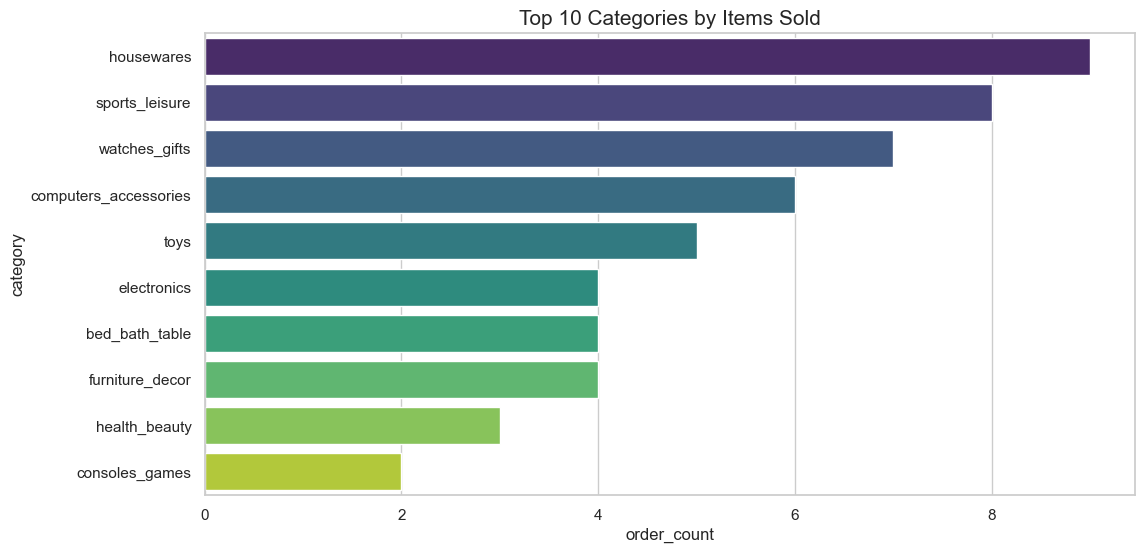

In [48]:
query22 = """
SELECT t.product_category_name_english AS category, COUNT(*) AS order_count
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
JOIN product_category_name_translation t ON p.product_category_name = t.product_category_name
GROUP BY category ORDER BY order_count DESC LIMIT 10;
"""
df22 = pd.read_sql(query22, con=engine)
plt.figure()
sns.barplot(data=df2, y='category', x='order_count', palette='viridis')
plt.title('Top 10 Categories by Items Sold', fontsize=15)
plt.show()

3. Payment Method Share (Pie or Donut Chart)
Question: What is the percentage distribution of payment types (Credit Card vs. Boleto vs. Voucher)?

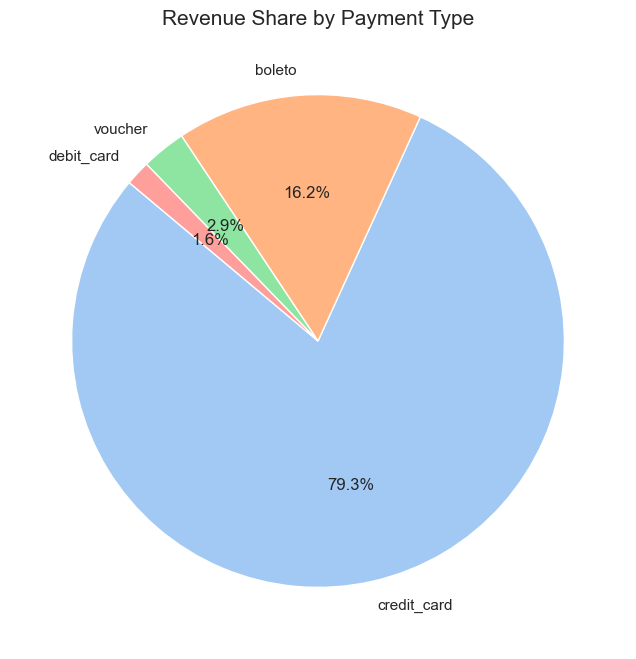

In [49]:
query23 = "SELECT payment_type, SUM(payment_value) AS total_value FROM order_payments GROUP BY payment_type;"
df23 = pd.read_sql(query23, con=engine)
plt.figure(figsize=(8, 8))
plt.pie(df3['total_value'], labels=df3['payment_type'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Revenue Share by Payment Type', fontsize=15)
plt.show()

4. Customer Satisfaction Distribution (Bar Chart)
Question: What is the overall distribution of review scores (1 to 5)?

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19108\2729933694.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df4, x='review_score', y='count', palette='magma')


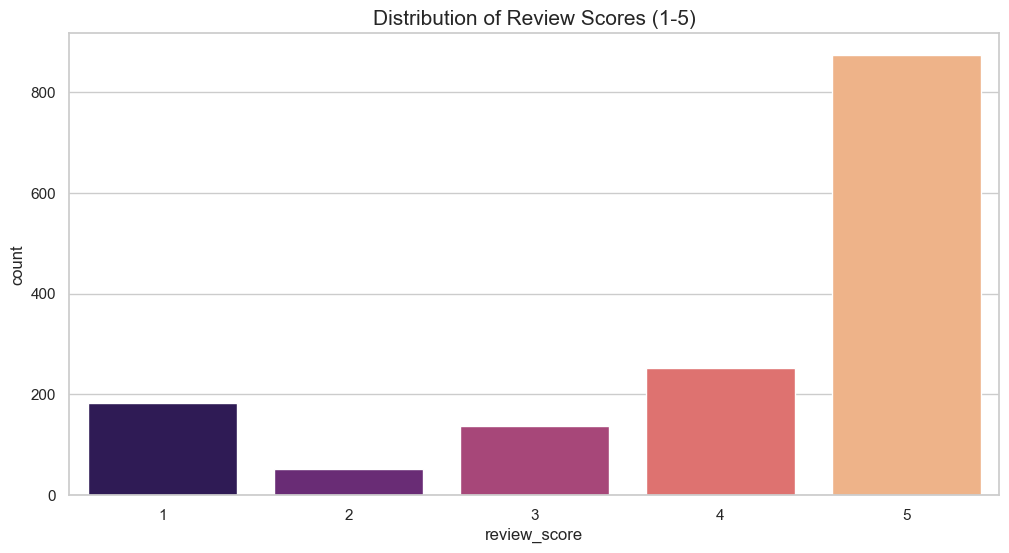

In [50]:
query24 = "SELECT review_score, COUNT(*) AS count FROM order_reviews GROUP BY review_score ORDER BY review_score;"
df24 = pd.read_sql(query24, con=engine)
plt.figure()
sns.barplot(data=df4, x='review_score', y='count', palette='magma')
plt.title('Distribution of Review Scores (1-5)', fontsize=15)
plt.show()

5. Delivery Performance by State (Bar Chart)
Question: What is the average delivery time (in days) for the top 10 most active states?

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19108\325764761.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df5, x='customer_state', y='avg_delivery_time', palette='coolwarm')


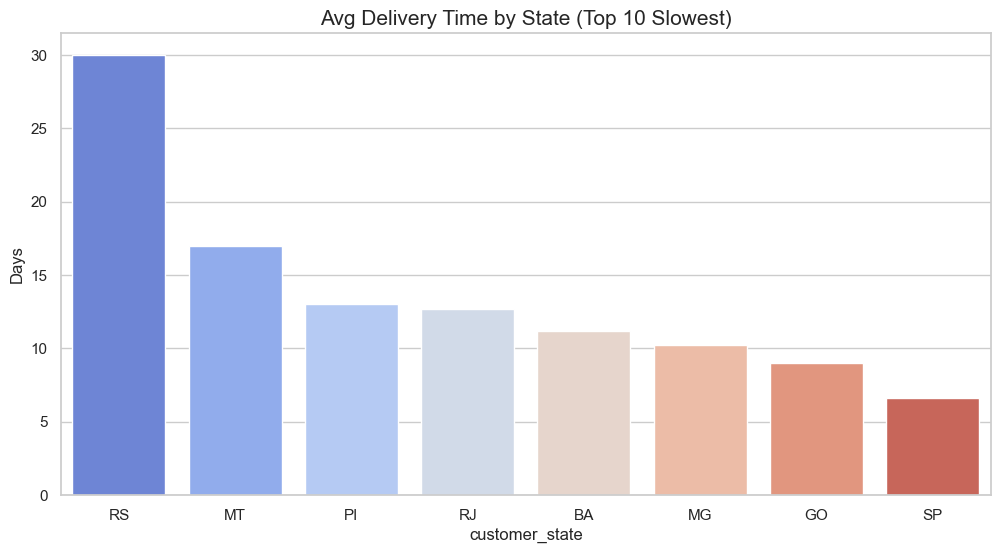

In [ ]:
query25 = """
SELECT c.customer_state, AVG(DATEDIFF(order_delivered_customer_date, order_purchase_timestamp)) AS avg_delivery_time
FROM orders o JOIN customers c ON o.customer_id = c.customer_id
WHERE order_status = 'delivered' GROUP BY c.customer_state ORDER BY avg_delivery_time DESC LIMIT 10;
"""
df25 = pd.read_sql(query25, con=engine)
plt.figure()
sns.barplot(data=df5, x='customer_state', y='avg_delivery_time', palette='coolwarm')
plt.title('Avg Delivery Time by State (Top 10 Slowest)', fontsize=15)
plt.ylabel('Days')
plt.show()

6. Hourly Shopping Patterns (Area or Bar Chart)
Question: At what time of day are customers most likely to place an order?

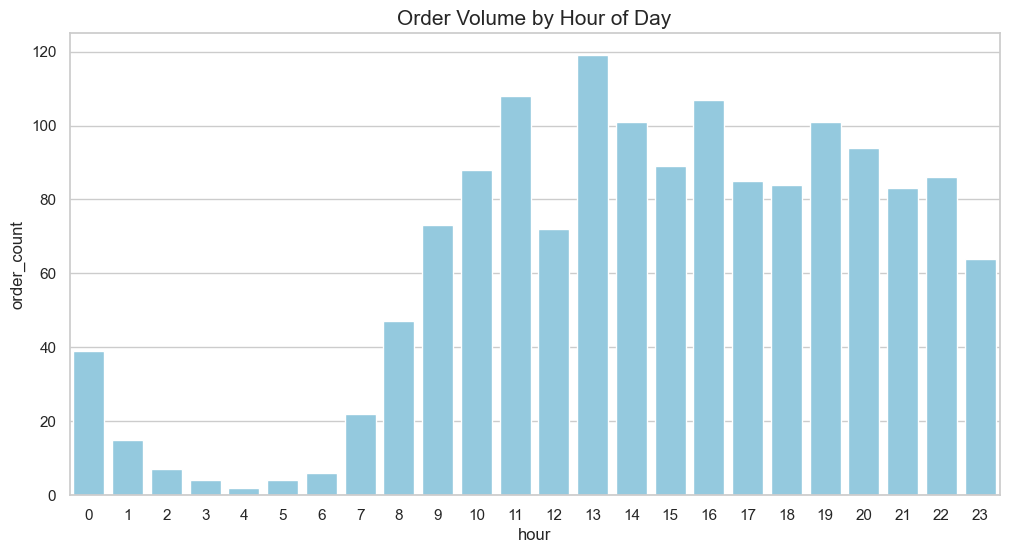

In [53]:
query26 = "SELECT HOUR(order_purchase_timestamp) AS hour, COUNT(*) AS order_count FROM orders GROUP BY hour ORDER BY hour;"
df26 = pd.read_sql(query26, con=engine)
plt.figure()
sns.barplot(data=df26, x='hour', y='order_count', color='skyblue')
plt.title('Order Volume by Hour of Day', fontsize=15)
plt.show()

7. Freight vs. Product Price (Scatter Plot)
Question: Is there a correlation between the price of an item and its freight cost?

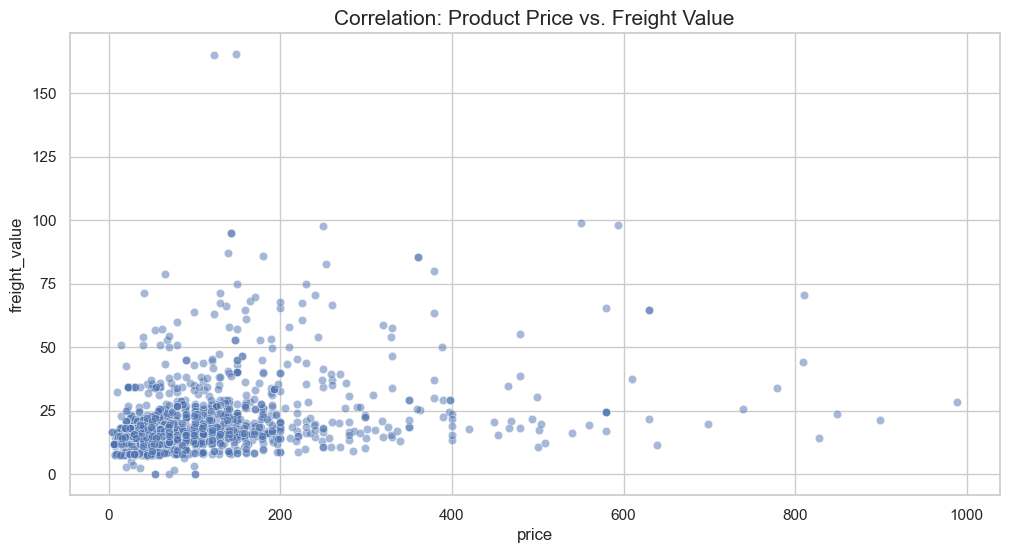

In [54]:
query27 = "SELECT price, freight_value FROM order_items WHERE price < 1000 AND freight_value < 200;"
df27 = pd.read_sql(query27, con=engine)
plt.figure()
sns.scatterplot(data=df27, x='price', y='freight_value', alpha=0.5)
plt.title('Correlation: Product Price vs. Freight Value', fontsize=15)
plt.show()

8. Order Volume by Day of the Week (Bar Chart)
Question: Which days of the week have the highest and lowest order volumes?

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19108\805432850.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df28, x='day', y='count', palette='Blues_d')


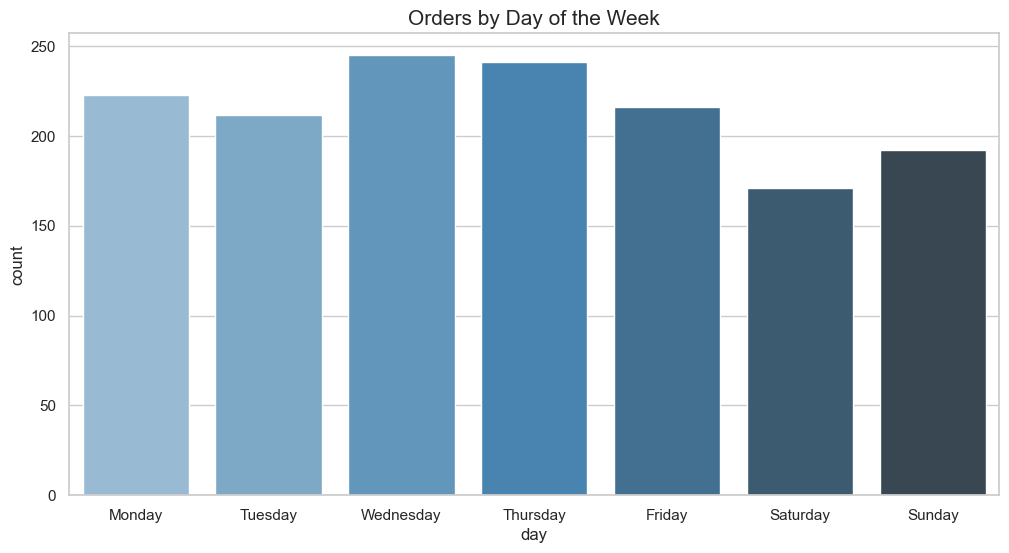

In [55]:
query28 = "SELECT DAYNAME(order_purchase_timestamp) AS day, COUNT(*) AS count FROM orders GROUP BY day ORDER BY FIELD(day, 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday');"
df28 = pd.read_sql(query28, con=engine)
plt.figure()
sns.barplot(data=df28, x='day', y='count', palette='Blues_d')
plt.title('Orders by Day of the Week', fontsize=15)
plt.show()

9. Price Range Distribution (Histogram)
Question: What are the most common price points for products sold on the platform?

Text(0.5, 1.0, 'Product Price Distribution (Under $R$500)')

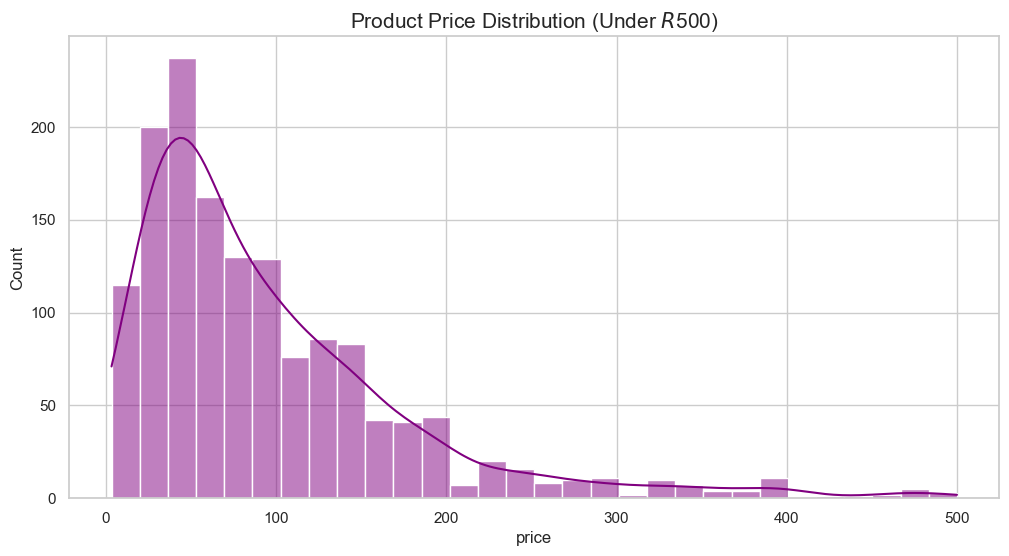

In [56]:
query29 = "SELECT price FROM order_items WHERE price < 500;"
df29 = pd.read_sql(query29, con=engine)
plt.figure()
sns.histplot(df29['price'], bins=30, kde=True, color='purple')
plt.title('Product Price Distribution (Under $R$500)', fontsize=15)

10. Seller Revenue vs. Rating (Scatter Plot)
Question: Do high-revenue sellers also have high review scores, or is there a trade-off?

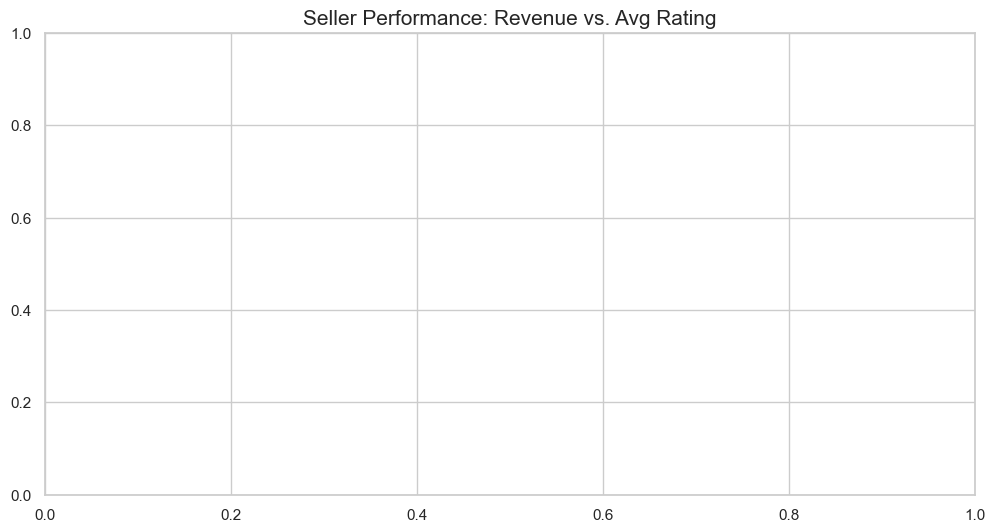

In [57]:
query30 = """
SELECT oi.seller_id, SUM(oi.price) AS revenue, AVG(orv.review_score) AS avg_rating
FROM order_items oi JOIN order_reviews orv ON oi.order_id = orv.order_id
GROUP BY oi.seller_id HAVING revenue > 500;
"""
df30 = pd.read_sql(query30, con=engine)
plt.figure()
sns.scatterplot(data=df30, x='revenue', y='avg_rating', alpha=0.6, color='green')
plt.title('Seller Performance: Revenue vs. Avg Rating', fontsize=15)
plt.show()

11. Order Processing Lead Times (Operational Efficiency)Question: How much time does each stage of the order fulfillment process take on average (Purchase $\rightarrow$ Approval $\rightarrow$ Carrier $\rightarrow$ Delivery)?Value: Identifies exactly where bottlenecks are occurring—whether it's payment approval, seller dispatch, or the shipping carrier.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19108\3443087497.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df11_melted, x='Stage', y='Days', palette='mako')


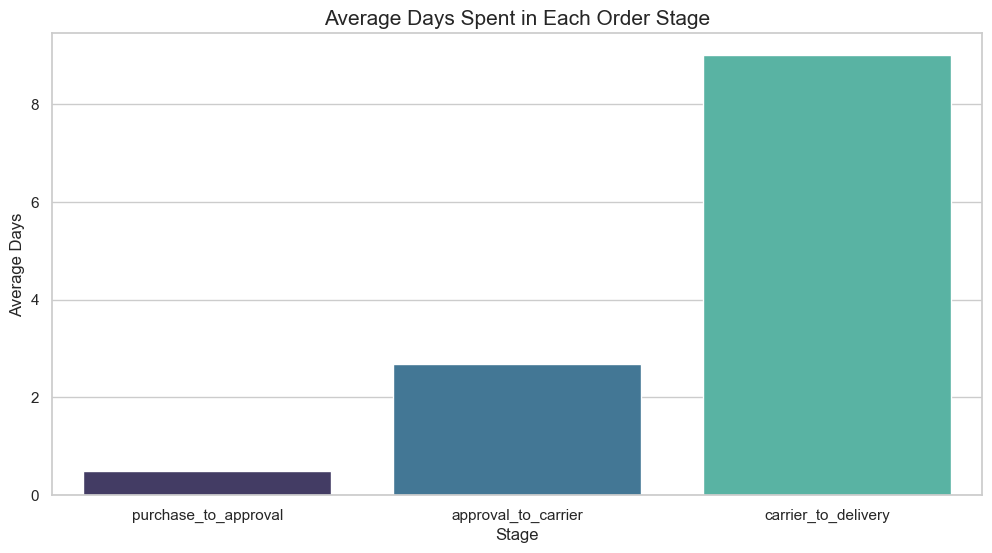

In [58]:
query11 = """
SELECT 
    AVG(DATEDIFF(order_approved_at, order_purchase_timestamp)) AS purchase_to_approval,
    AVG(DATEDIFF(order_delivered_carrier_date, order_approved_at)) AS approval_to_carrier,
    AVG(DATEDIFF(order_delivered_customer_date, order_delivered_carrier_date)) AS carrier_to_delivery
FROM orders
WHERE order_status = 'delivered';
"""
df11 = pd.read_sql(query11, con=engine)
# Transpose for easier plotting
df11_melted = df11.melt(var_name='Stage', value_name='Days')

plt.figure()
sns.barplot(data=df11_melted, x='Stage', y='Days', palette='mako')
plt.title('Average Days Spent in Each Order Stage', fontsize=15)
plt.ylabel('Average Days')
plt.show()

12. Installment Counts Distribution (Financial Behavior)
Question: How many installments do customers typically choose when paying? Value: Helps the finance team understand credit risk and decide if offering more installments (like 12 or 24) would benefit the business.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19108\706750364.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df12, x='payment_installments', y='order_count', palette='viridis')


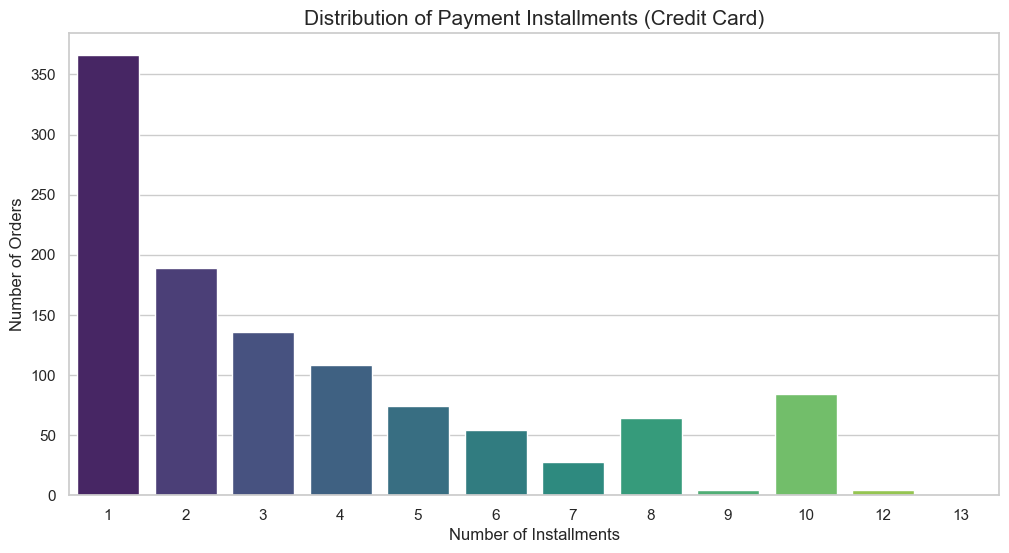

In [59]:
query12 = """
SELECT payment_installments, COUNT(*) AS order_count 
FROM order_payments 
WHERE payment_type = 'credit_card' 
GROUP BY payment_installments 
ORDER BY payment_installments;
"""
df12 = pd.read_sql(query12, con=engine)

plt.figure()
sns.barplot(data=df12, x='payment_installments', y='order_count', palette='viridis')
plt.title('Distribution of Payment Installments (Credit Card)', fontsize=15)
plt.xlabel('Number of Installments')
plt.ylabel('Number of Orders')
plt.show()

13. Seller Concentration by State (Supply Chain Mapping)
Question: Which states have the highest concentration of sellers? Value: Assists the logistics team in determining where to build sorting centers or warehouses to be closer to the supply.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19108\175658026.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df13, x='seller_state', y='seller_count', palette='magma')


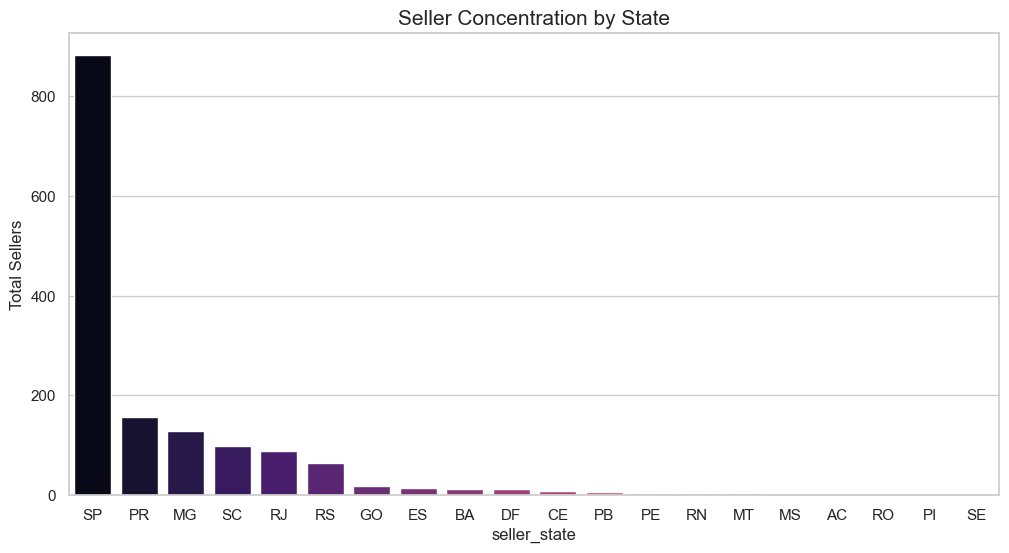

In [60]:
query13 = "SELECT seller_state, COUNT(*) AS seller_count FROM sellers GROUP BY seller_state ORDER BY seller_count DESC;"
df13 = pd.read_sql(query13, con=engine)

plt.figure()
sns.barplot(data=df13, x='seller_state', y='seller_count', palette='magma')
plt.title('Seller Concentration by State', fontsize=15)
plt.ylabel('Total Sellers')
plt.show()

14. Review Score vs. Feedback Depth (Customer Sentiment)
Question: Do customers write longer reviews when they are unhappy (score 1-2) or happy (score 5)? Value: Helps the customer service team prioritize which reviews need immediate manual reading (e.g., long reviews with low scores usually contain detailed complaints).

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19108\1960815394.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df14, x='review_score', y='comment_length', palette='Set2')


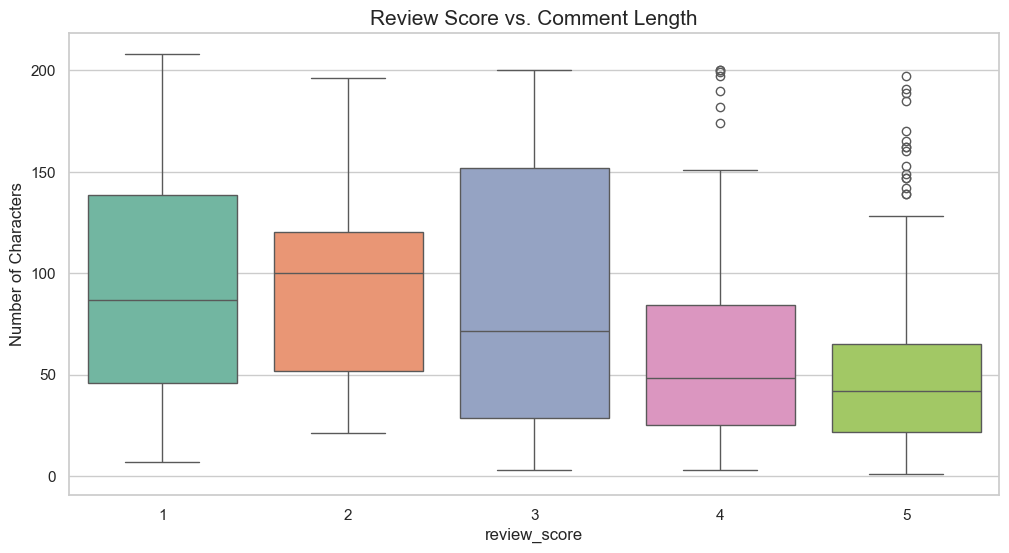

In [61]:
query14 = """
SELECT review_score, CHAR_LENGTH(review_comment_message) AS comment_length 
FROM order_reviews 
WHERE review_comment_message IS NOT NULL;
"""
df14 = pd.read_sql(query14, con=engine)

plt.figure()
sns.boxplot(data=df14, x='review_score', y='comment_length', palette='Set2')
plt.title('Review Score vs. Comment Length', fontsize=15)
plt.ylabel('Number of Characters')
plt.show()

15. Impact of Product Photos on Sales (Content Strategy)
Question: Does having more photos (0 to 10+) lead to a higher volume of sales for a product? Value: Provides a clear "Quality Standard" for sellers—if products with 5 photos sell 2x more than those with 1, you can mandate a minimum photo count.

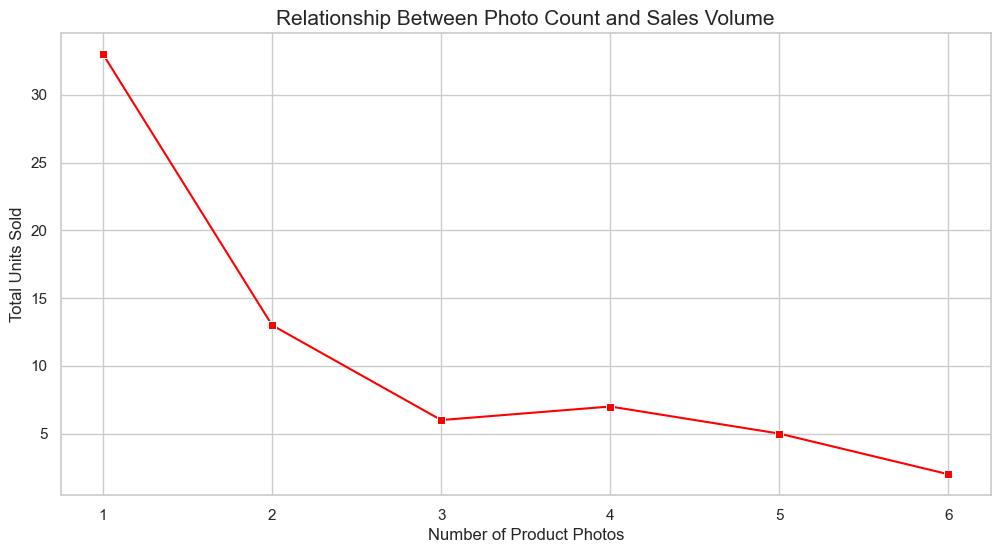

In [62]:
query15 = """
SELECT p.product_photos_qty, COUNT(oi.order_id) AS sales_volume
FROM products p
JOIN order_items oi ON p.product_id = oi.product_id
WHERE p.product_photos_qty IS NOT NULL
GROUP BY p.product_photos_qty
ORDER BY p.product_photos_qty;
"""
df15 = pd.read_sql(query15, con=engine)

plt.figure()
sns.lineplot(data=df15, x='product_photos_qty', y='sales_volume', marker='s', color='red')
plt.title('Relationship Between Photo Count and Sales Volume', fontsize=15)
plt.xlabel('Number of Product Photos')
plt.ylabel('Total Units Sold')
plt.show()